# L2-A - Linear Quantization I: Quantize and De-quantize a Tensor

## Quantization with Random `Scale` and `Zero Point`

- Implement Linear Quantization for when the "scale" and the "zero point" are known/randomly selected.

In [45]:
import torch

In [46]:
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=torch.int8):
    scaled_and_shifted_tensor = tensor/scale + zero_point # r = s(q - z) -> q = r/s + z

    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max

    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)

    return q_tensor

In [47]:
### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [48]:
# random values for scale and zero point
scale = 3.2
zero_point = -50

In [49]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale, zero_point)
quantized_tensor

tensor([[  10,  -54,  127],
        [ -21,   42, -108],
        [ -50,  127,   27]], dtype=torch.int8)

## Dequantization with Random `Scale` and `Zero Point`
- Now, Dequantize the tensor to see how precise the quantization is.

In [50]:
dequantized_tensor = scale*(quantized_tensor.float() - zero_point)
dequantized_tensor
# original tensor
# [[191.6, -13.5, 728.6],
#  [92.14, 295.5,  -184],
#  [0,     684.6, 245.5]]

tensor([[ 192.0000,  -12.8000,  566.4000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000,  566.4000,  246.4000]])

In [51]:
# without casting to float
dequantized_tensor = scale*(quantized_tensor - zero_point)
dequantized_tensor # some values are different due to overflow or underflow

tensor([[ 192.0000,  -12.8000, -252.8000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000, -252.8000,  246.4000]])

In [52]:
def linear_dequantization(tensor, scale, zero_point):
    return scale*(tensor.float() - zero_point)

In [53]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)
dequantized_tensor

tensor([[ 192.0000,  -12.8000,  566.4000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000,  566.4000,  246.4000]])

### Quantization Error
- Load the `plot_quantization_errors` from the helper file.
- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [54]:
from helper import plot_quantization_errors

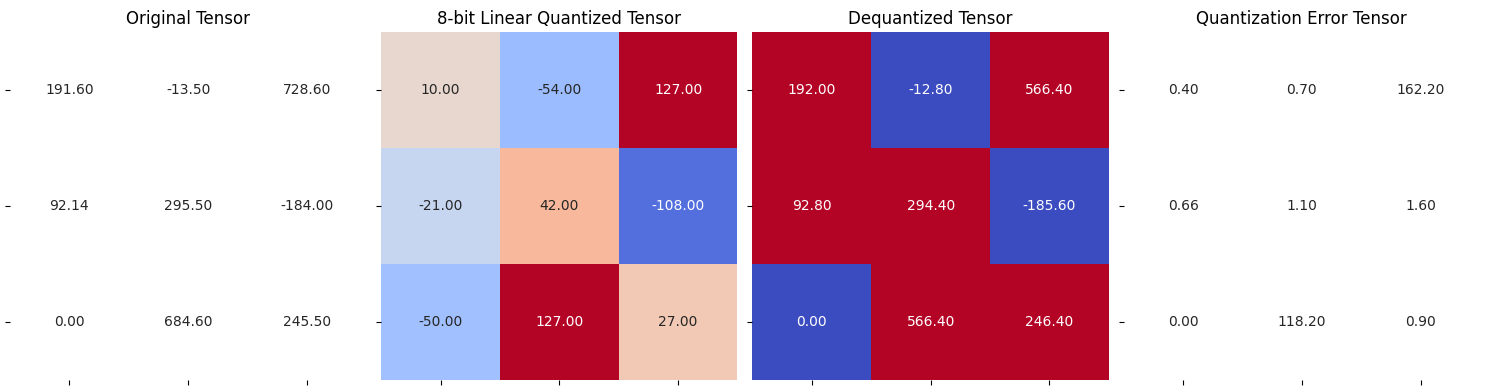

In [55]:
plot_quantization_errors(test_tensor, quantized_tensor,
                         dequantized_tensor)

**Note:** For the plot above, `Quantization Error Tensor = abs(Original Tensor - Dequantized Tensor)`

- Calculate an "overall" quantization error by using [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) technique.

In [56]:
dequantized_tensor - test_tensor

tensor([[   0.4000,    0.7000, -162.2000],
        [   0.6600,   -1.1000,   -1.6000],
        [   0.0000, -118.2000,    0.9000]])

In [57]:
(dequantized_tensor - test_tensor).square()

tensor([[1.6000e-01, 4.9000e-01, 2.6309e+04],
        [4.3560e-01, 1.2100e+00, 2.5600e+00],
        [0.0000e+00, 1.3971e+04, 8.1002e-01]])

In [58]:
(dequantized_tensor - test_tensor).square().mean()

tensor(4476.1909)

# L2-B - Linear Quantization I: Get the Scale and Zero Point

In this lesson, continue to learn about fundamentals of linear quantization, and implement your own Linear Quantizer.

## Finding `Scale` and `Zero Point` for Quantization

In [59]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max
q_min, q_max

(-128, 127)

In [60]:
r_min = test_tensor.min().item()
r_max = test_tensor.max().item()
r_min, r_max

(-184.0, 728.5999755859375)

In [61]:
scale = (r_max - r_min) / (q_max - q_min)
scale

3.578823433670343

In [62]:
zero_point = q_min - (r_min / scale)
zero_point

-76.58645490333825

In [63]:
zero_point = int(round(zero_point))
zero_point

-77

Make it into a function

In [64]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = q_min - (r_min / scale)

    # clip the zero point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))
    
    return scale, zero_point

- Test the implementation using the `test_tensor` defined earlier.
```Python
[[191.6, -13.5, 728.6],
 [92.14, 295.5,  -184],
 [0,     684.6, 245.5]]
```

In [65]:
new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)
new_scale, new_zero_point

(3.578823433670343, -77)

## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

- Use the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [66]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, new_scale, new_zero_point)
quantized_tensor

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)

In [67]:
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)
dequantized_tensor

tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

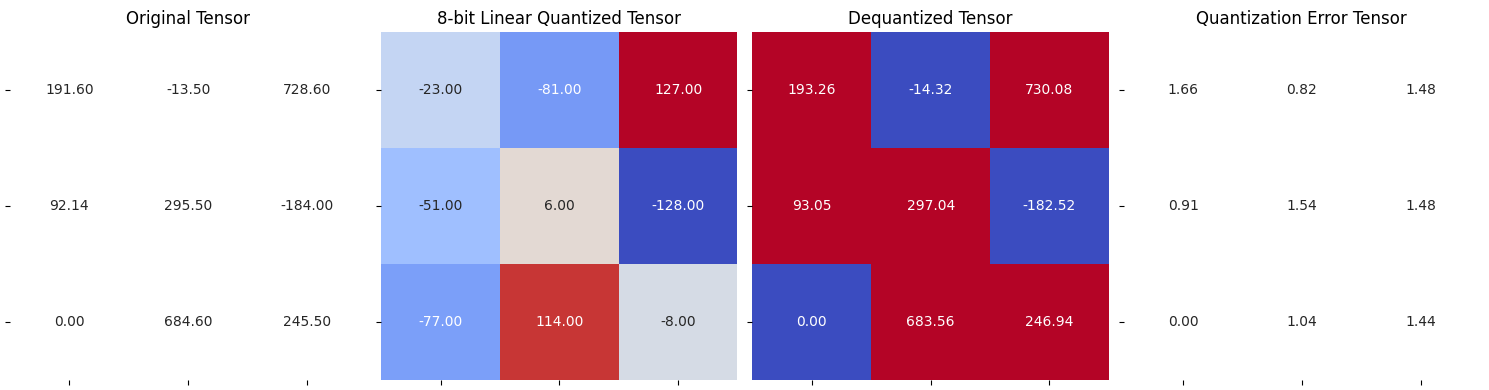

In [68]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [69]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [70]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, dtype=dtype)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point)

    return quantized_tensor, scale, zero_point

- Test implementation on a random matrix.

In [74]:
r_tensor = torch.randn((4,4))
r_tensor

tensor([[-1.7276, -2.1936, -0.1716, -0.3403],
        [-0.9934, -0.0714, -2.0432, -0.8481],
        [-0.7745,  0.5289, -0.1673,  0.9091],
        [ 0.6995, -0.3250,  0.5159, -0.4935]])

In [76]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [77]:
quantized_tensor

tensor([[ -90, -128,   38,   24],
        [ -30,   46, -116,  -18],
        [ -12,   95,   38,  127],
        [ 109,   25,   94,   11]], dtype=torch.int8)

In [78]:
scale

0.012167289911531935

In [79]:
zero_point

52

In [81]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

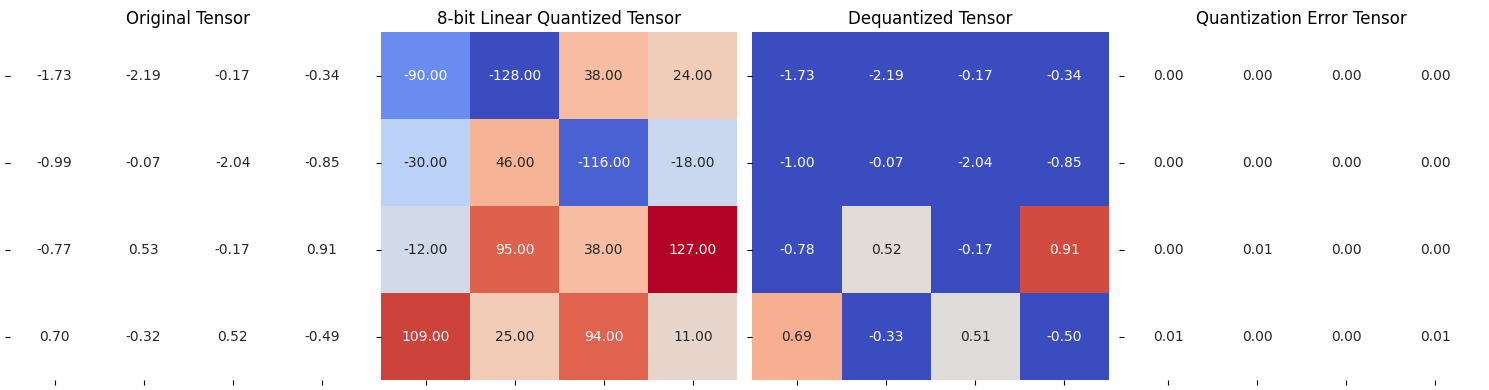

In [82]:
plot_quantization_errors(r_tensor, quantized_tensor, dequantized_tensor)

In [83]:
(dequantized_tensor - r_tensor).square().mean()

tensor(1.3877e-05)